# Distributed CBO -- Benchmark and Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import math
import time

import matplotlib.pyplot as plt
import numpy as np

from cbx.dynamics import CBO, DistributedCBO
from cbx.objectives import Rastrigin, Ackley, Michalewicz
import cbx.utils.termination as term

# CBO Configuration

In [2]:
conf = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,
    'lamda': 1.0,
    'term_criteria': [term.max_it_term(100)],
    'track_args': {'names': ['update_norm', 'energy', 'x', 'consensus', 'drift']},

    'noise': 'anisotropic',
    'f_dim': '3D'
}

# Define Benchmarking Functions

In [3]:
def benchmark_distributed_cbo(
    f: callable,
    num_runs: int,
    max_splitting_factor: int,
    max_particles: int,
    synchronization_interval: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
):  
    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    for splitting_factor in range(1, max_splitting_factor + 1):
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                use_async_communication=use_async_communication,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Splitting factor: {splitting_factor}, average energy: {average_energy}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.plot(list(range(1, max_splitting_factor + 1)), energy_means, label=f'Distributed CBO {async_label}')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        axs.fill_between(list(range(1, max_splitting_factor + 1)), quantile_10, quantile_90, alpha=0.3, label='90% CI')


In [4]:
def benchmark_standard_cbo(
    f: callable,
    num_runs: int,
    num_particles: int,
    axs=None,
):
    energies = []
    execution_times = []
    function_evaluations = []
    for _ in range(num_runs):
        dyn = CBO(
            f,
            N=num_particles,
            verbosity=0,
            max_it=10000,
            batch_args=None,
            M=1,
            **conf
        )

        # Run optimization and measure time
        tick = time.time()
        energies.append(
            f(dyn.optimize())
        )
        tock = time.time()
        execution_times.append(tock - tick)

        function_evaluations.append(dyn.num_f_eval)

    average_energy = np.median(energies)
    average_function_evaluations = np.mean(function_evaluations)
    print(f"Average energy: {average_energy}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")

    # Plot mean of undistributed energies as a horizontal line
    if axs is not None:
        axs.axhline(y=average_energy, color='r', linestyle='--', label='Standard CBO')


# Benchmark

In [5]:
# Benchmarking params
NUM_RUNS = 100
MAX_SPLITTING_FACTOR = 10
MAX_PARTICLES = 100
SYNCHRONIZATION_INTERVAL = 10
SYNCHRONIZATION_METHOD = 'weighted_mean'

In [6]:
def run_experiment(
    f: callable,
    d: int,
    n: int
):
    fig, axs = plt.subplots(1, 1)

    conf['d'] = d
    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    benchmark_distributed_cbo(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=1000000,   # Arbitrarily high number since we depend on the termination criteria
        axs=axs
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    benchmark_distributed_cbo(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs.set_xlabel(f"Splitting factor")
    axs.set_ylabel(f"Mean energy")
    axs.set_title(f"{function_label}\nsync interval: {SYNCHRONIZATION_INTERVAL}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs.legend()
    
    fig.show()

## Ackley (d = 5, 10, 20; N = 50, 100, 200, 1000)

Standard CBO:
Average energy: 0.023858202480278923, function evaluations: 5050.0, execution time: 0.009307923316955567

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.018370509161896198, function evaluations: 5050.0, execution time: 0.020485615730285643
Splitting factor: 2, average energy: 0.016227687086097564, function evaluations: 5050.0, execution time: 0.023257423639297486
Splitting factor: 3, average energy: 0.022673489130492275, function evaluations: 5083.666666666667, execution time: 0.026410420735677082
Splitting factor: 4, average energy: 0.026144066879393524, function evaluations: 5125.75, execution time: 0.03030650198459625
Splitting factor: 5, average energy: 0.035270797073171156, function evaluations: 5110.6, execution time: 0.034438767910003665
Splitting factor: 6, average energy: 0.03419880080865889, function evaluations: 5167.833333333333, execution time: 0.038176732858022054
Splitting factor: 7, average energy: 0.0313578339504752, f

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


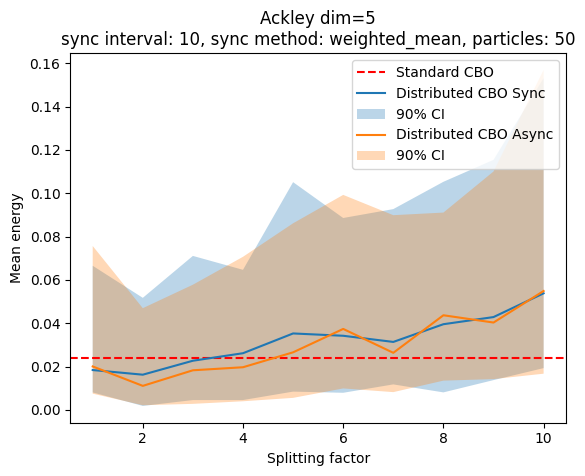

In [7]:
run_experiment(Ackley(), d=5, n=50)

Standard CBO:
Average energy: 0.13231287628908506, function evaluations: 5050.0, execution time: 0.00862001657485962

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.1444274774087586, function evaluations: 5050.0, execution time: 0.01770577669143677
Splitting factor: 2, average energy: 0.10890815265537812, function evaluations: 5050.0, execution time: 0.02022060751914978
Splitting factor: 3, average energy: 0.1150425299561264, function evaluations: 5083.666666666667, execution time: 0.025862939357757568
Splitting factor: 4, average energy: 0.14257171235810384, function evaluations: 5125.75, execution time: 0.03191264450550079
Splitting factor: 5, average energy: 0.15962558400769788, function evaluations: 5110.6, execution time: 0.03729562377929688
Splitting factor: 6, average energy: 0.15655182957334768, function evaluations: 5167.833333333333, execution time: 0.04133798678716024
Splitting factor: 7, average energy: 0.1660375978383155, function evalu

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


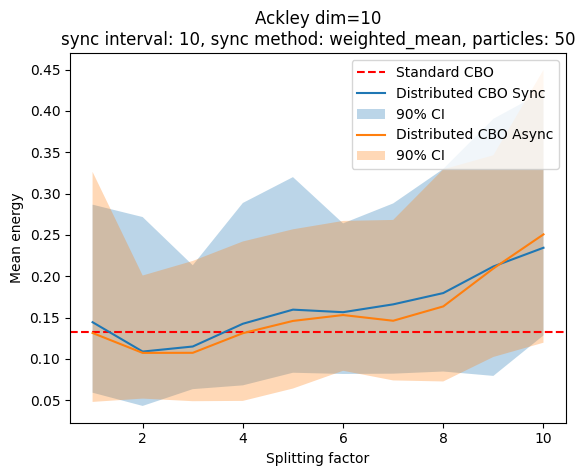

In [8]:
run_experiment(Ackley(), d=10, n=50)

Standard CBO:
Average energy: 0.47146928282014366, function evaluations: 5050.0, execution time: 0.009839682579040528

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.4612889216253806, function evaluations: 5050.0, execution time: 0.01999799966812134
Splitting factor: 2, average energy: 0.3670390746466219, function evaluations: 5050.0, execution time: 0.022454248666763307
Splitting factor: 3, average energy: 0.3879952832200826, function evaluations: 5083.666666666667, execution time: 0.025485194524129232
Splitting factor: 4, average energy: 0.3805526348909489, function evaluations: 5125.75, execution time: 0.02951523184776306
Splitting factor: 5, average energy: 0.4264296630653601, function evaluations: 5110.6, execution time: 0.033766351222991944
Splitting factor: 6, average energy: 0.39806949062610686, function evaluations: 5167.833333333333, execution time: 0.03807375192642212
Splitting factor: 7, average energy: 0.40670175408009657, function eval

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


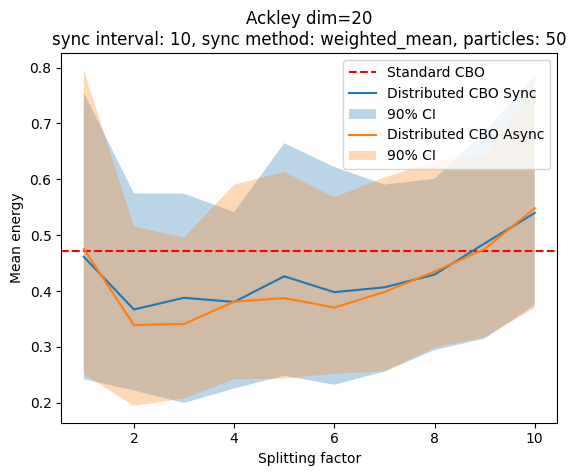

In [9]:
run_experiment(Ackley(), d=20, n=50)

Standard CBO:
Average energy: 0.010670975217749845, function evaluations: 10100.0, execution time: 0.008584034442901612

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.011764010804660163, function evaluations: 10100.0, execution time: 0.01662680387496948
Splitting factor: 2, average energy: 0.010733094038473556, function evaluations: 10100.0, execution time: 0.01939759135246277
Splitting factor: 3, average energy: 0.008509636376203833, function evaluations: 10167.333333333334, execution time: 0.02344137668609619
Splitting factor: 4, average energy: 0.009219929629628698, function evaluations: 10150.5, execution time: 0.030894238352775574
Splitting factor: 5, average energy: 0.00898179078145711, function evaluations: 10140.4, execution time: 0.03544389915466309
Splitting factor: 6, average energy: 0.009265909975475939, function evaluations: 10167.333333333334, execution time: 0.04019775629043579
Splitting factor: 7, average energy: 0.00963580652958429

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


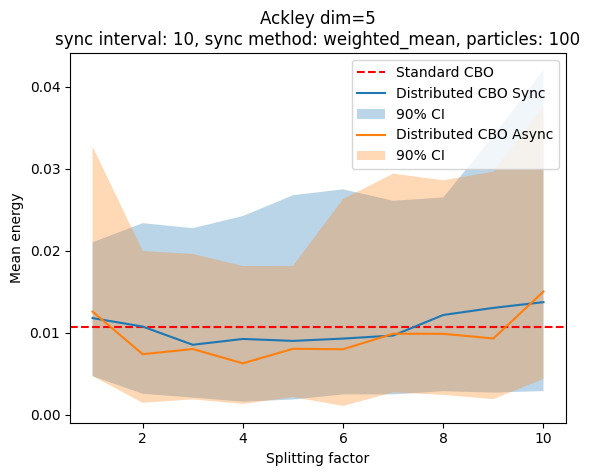

In [10]:
run_experiment(Ackley(), d=5, n=100)

Standard CBO:
Average energy: 0.05884700676538879, function evaluations: 10100.0, execution time: 0.010193557739257812

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.061215260616018785, function evaluations: 10100.0, execution time: 0.019731650352478026
Splitting factor: 2, average energy: 0.04666651708587155, function evaluations: 10100.0, execution time: 0.022934218645095827
Splitting factor: 3, average energy: 0.0527412192167227, function evaluations: 10167.333333333334, execution time: 0.0280594539642334
Splitting factor: 4, average energy: 0.05509883075986943, function evaluations: 10150.5, execution time: 0.033191458582878114
Splitting factor: 5, average energy: 0.06910710837226697, function evaluations: 10140.4, execution time: 0.0381823935508728
Splitting factor: 6, average energy: 0.06708276607993335, function evaluations: 10167.333333333334, execution time: 0.04236665447552999
Splitting factor: 7, average energy: 0.067741138835816, functi

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


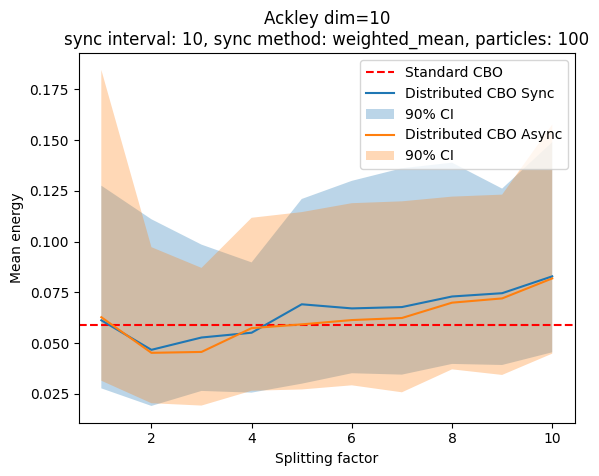

In [11]:
run_experiment(Ackley(), d=10, n=100)

Standard CBO:
Average energy: 0.2299395905995394, function evaluations: 10100.0, execution time: 0.012601711750030518

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.22580666779286895, function evaluations: 10100.0, execution time: 0.02109377145767212
Splitting factor: 2, average energy: 0.18438598548337426, function evaluations: 10100.0, execution time: 0.025634114742279054
Splitting factor: 3, average energy: 0.1886714401035321, function evaluations: 10167.333333333334, execution time: 0.030355960528055826
Splitting factor: 4, average energy: 0.1943540643945778, function evaluations: 10150.5, execution time: 0.03479137003421783
Splitting factor: 5, average energy: 0.2061699370798551, function evaluations: 10140.4, execution time: 0.03993828582763672
Splitting factor: 6, average energy: 0.1983487655475522, function evaluations: 10167.333333333334, execution time: 0.046584677696228025
Splitting factor: 7, average energy: 0.20088197209682557, functio

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


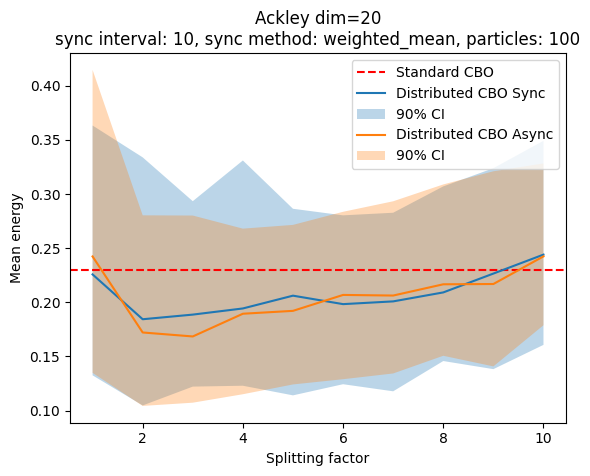

In [12]:
run_experiment(Ackley(), d=20, n=100)

Standard CBO:
Average energy: 0.007978474496580734, function evaluations: 20200.0, execution time: 0.010260007381439208

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.007950476452049049, function evaluations: 20200.0, execution time: 0.017831089496612548
Splitting factor: 2, average energy: 0.007459606649105499, function evaluations: 20200.0, execution time: 0.02059099555015564
Splitting factor: 3, average energy: 0.005399966603626627, function evaluations: 20233.666666666668, execution time: 0.024751540025075278
Splitting factor: 4, average energy: 0.006192248282838708, function evaluations: 20225.25, execution time: 0.02944996416568756
Splitting factor: 5, average energy: 0.004565308544928204, function evaluations: 20220.2, execution time: 0.034172219753265384
Splitting factor: 6, average energy: 0.003960815209822943, function evaluations: 20284.166666666668, execution time: 0.03847684303919474
Splitting factor: 7, average energy: 0.0043732457102

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


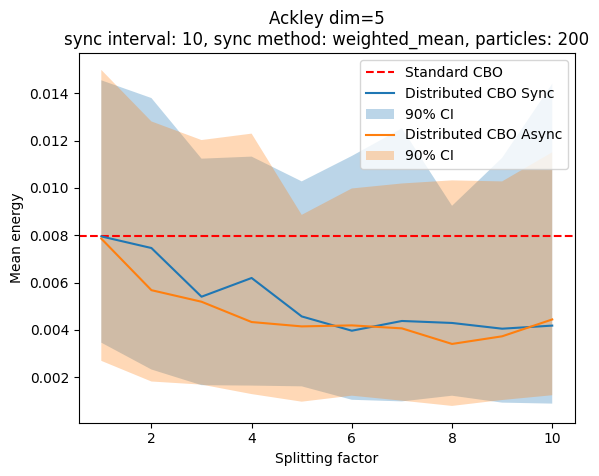

In [13]:
run_experiment(Ackley(), d=5, n=200)

Standard CBO:
Average energy: 0.03228712557919744, function evaluations: 20200.0, execution time: 0.013324978351593018

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.035894153773695425, function evaluations: 20200.0, execution time: 0.023092999458312988
Splitting factor: 2, average energy: 0.02845459507753434, function evaluations: 20200.0, execution time: 0.029087319374084472
Splitting factor: 3, average energy: 0.02536067210361681, function evaluations: 20233.666666666668, execution time: 0.034005429744720456
Splitting factor: 4, average energy: 0.026342631220720225, function evaluations: 20225.25, execution time: 0.03726662397384643
Splitting factor: 5, average energy: 0.02812265543121173, function evaluations: 20220.2, execution time: 0.04227847242355347
Splitting factor: 6, average energy: 0.03065898550063162, function evaluations: 20284.166666666668, execution time: 0.047554124196370444
Splitting factor: 7, average energy: 0.03283975477650047

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


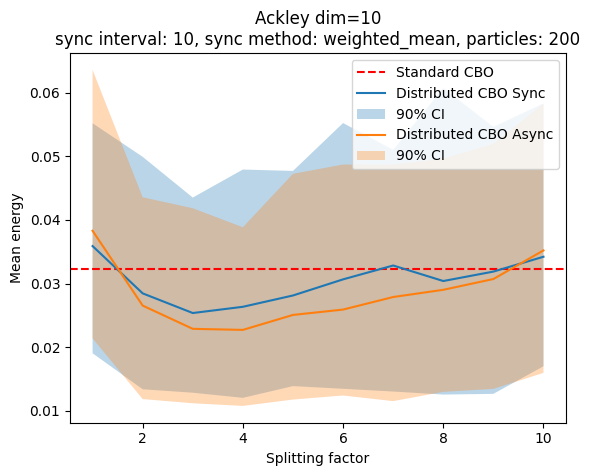

In [14]:
run_experiment(Ackley(), d=10, n=200)

Standard CBO:
Average energy: 0.12435729120923478, function evaluations: 20200.0, execution time: 0.018027799129486086

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.12268497189897021, function evaluations: 20200.0, execution time: 0.028446872234344483
Splitting factor: 2, average energy: 0.10493260955003025, function evaluations: 20200.0, execution time: 0.030745975971221924
Splitting factor: 3, average energy: 0.1064269120692356, function evaluations: 20233.666666666668, execution time: 0.037008323669433595
Splitting factor: 4, average energy: 0.10301305685673023, function evaluations: 20225.25, execution time: 0.045441315174102784
Splitting factor: 5, average energy: 0.11119845161771247, function evaluations: 20220.2, execution time: 0.05329246854782105
Splitting factor: 6, average energy: 0.10216628668009031, function evaluations: 20284.166666666668, execution time: 0.06013199011484782
Splitting factor: 7, average energy: 0.10788809971886737, f

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


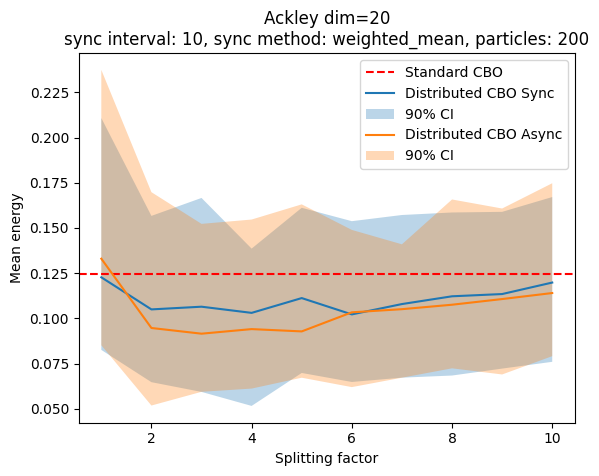

In [15]:
run_experiment(Ackley(), d=20, n=200)

Standard CBO:
Average energy: 0.0028818197978446314, function evaluations: 101000.0, execution time: 0.02722799062728882

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.003288211855581924, function evaluations: 101000.0, execution time: 0.03848375797271728
Splitting factor: 2, average energy: 0.0034487208367246502, function evaluations: 101000.0, execution time: 0.03798981308937073
Splitting factor: 3, average energy: 0.0028913633040876796, function evaluations: 101067.33333333333, execution time: 0.042960391839345295
Splitting factor: 4, average energy: 0.0025472097606447086, function evaluations: 101050.5, execution time: 0.0512910670042038
Splitting factor: 5, average energy: 0.0022554214707963816, function evaluations: 101040.4, execution time: 0.05875581073760986
Splitting factor: 6, average energy: 0.001872827180282588, function evaluations: 101067.33333333333, execution time: 0.06831183950106302
Splitting factor: 7, average energy: 0.00177374

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


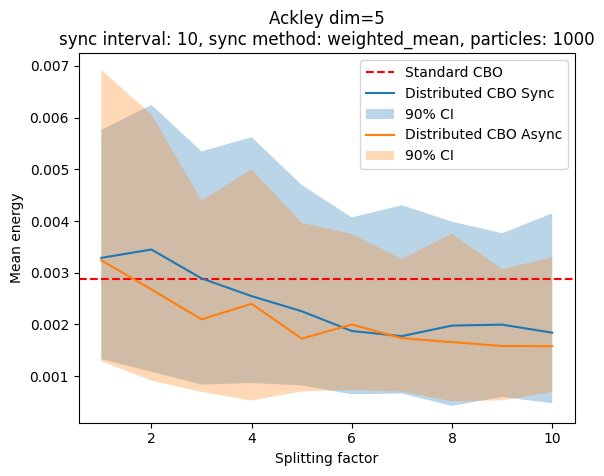

In [16]:
run_experiment(Ackley(), d=5, n=1000)

Standard CBO:
Average energy: 0.019601669724313542, function evaluations: 101000.0, execution time: 0.03905164241790771

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.019574347310428397, function evaluations: 101000.0, execution time: 0.04854928731918335
Splitting factor: 2, average energy: 0.016923676909130325, function evaluations: 101000.0, execution time: 0.06047597527503967
Splitting factor: 3, average energy: 0.013860967441987615, function evaluations: 101067.33333333333, execution time: 0.06235702673594157
Splitting factor: 4, average energy: 0.012811170977821806, function evaluations: 101050.5, execution time: 0.06609824597835541
Splitting factor: 5, average energy: 0.011972200794023724, function evaluations: 101040.4, execution time: 0.07105679941177369
Splitting factor: 6, average energy: 0.010456414209541354, function evaluations: 101067.33333333333, execution time: 0.07727126836776733
Splitting factor: 7, average energy: 0.0105263533025

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


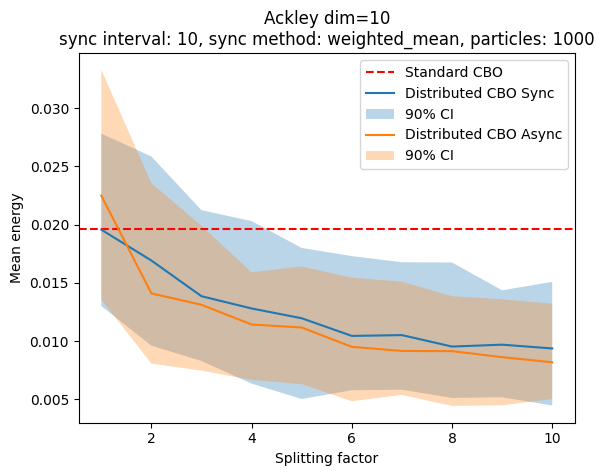

In [17]:
run_experiment(Ackley(), d=10, n=1000)

Standard CBO:
Average energy: 0.05689282288347508, function evaluations: 101000.0, execution time: 0.062308521270751954

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.06002186117211972, function evaluations: 101000.0, execution time: 0.0816719388961792
Splitting factor: 2, average energy: 0.0480808806781039, function evaluations: 101000.0, execution time: 0.0705485212802887
Splitting factor: 3, average energy: 0.03927026351857643, function evaluations: 101067.33333333333, execution time: 0.07442013104756673
Splitting factor: 4, average energy: 0.03641921384772795, function evaluations: 101050.5, execution time: 0.08348799288272858
Splitting factor: 5, average energy: 0.035452219456634015, function evaluations: 101040.4, execution time: 0.0894586672782898
Splitting factor: 6, average energy: 0.035563873919983724, function evaluations: 101067.33333333333, execution time: 0.09598257621129354
Splitting factor: 7, average energy: 0.03523448933697226, fu

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_82696/1900651575.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


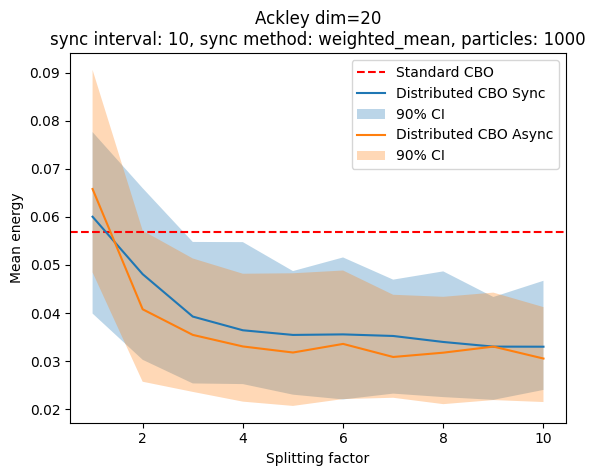

In [18]:
run_experiment(Ackley(), d=20, n=1000)